### Imports

In [ ]:
# !pip install plotly

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import add_Loss, clean_data
import umap
from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import tqdm, trange
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

## Import and clean data 

In [2]:
#Select the dataset of one season of one year
YEAR = 2019
SEASON = "Rabi" # or "Kharif" 

#Path to the dataset
pathData_R = f"Data\RawDataUnified\RawData_{YEAR}_Rabi"
pathData_K= f"Data\RawDataUnified\RawData_{YEAR}_Kharif"


df_R = pd.read_csv(pathData_R)
df_K=pd.read_csv(pathData_K)

In [3]:
#Clean an add loss to data
df_R=add_Loss(clean_data(df_R))
df_K=add_Loss(clean_data(df_K))

df_K.head()

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Sum Insured (Inr),Indemnity Level,2002 Yield,2003 Yield,2004 Yield,2005 Yield,...,2009 Yield,2010 Yield,2011 Yield,2012 Yield,2013 Yield,2014 Yield,2015 Yield,2016 Yield,2017 Yield,Loss
key,,,,,,,,,,,,,,,,,,,,,
andhra pradesh_anantapur_agali__agali,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,264.534667,150.820333,87.096222,108.775,70.0,295.0,89.0,99.0,2888.776861,14230.814316
andhra pradesh_anantapur_agali__akkagaladevarahalli,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,264.534667,150.820333,87.096222,108.775,58.0,232.0,120.0,99.0,2888.776861,14464.016467
andhra pradesh_anantapur_agali__hulikeradevarahalli,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,264.534667,150.820333,87.096222,108.775,67.0,295.0,89.0,99.0,2888.776861,14230.814316
andhra pradesh_anantapur_agali__inagalore,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,264.534667,150.820333,87.096222,108.775,62.0,232.0,120.0,99.0,2888.776861,14464.016467
andhra pradesh_anantapur_agali__kodihalli,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,264.534667,150.820333,87.096222,108.775,70.0,295.0,89.0,99.0,2888.776861,14230.814316


## UMAP embeding

In [9]:
#Preprocessing numerical
numerical = df.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = df.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df.select_dtypes(include='object').columns) / df.shape[1]

In [10]:
# from umap import UMAP

fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

In [11]:
import umap.umap_ as uu

# #Augmenting the numerical embedding with categorical
intersection = uu.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = uu.reset_local_connectivity(intersection)
embedding = uu.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, densmap_kwds="Salut", output_dens=False)

embedding=embedding[0]
np.save(f"embedding_{SEASON}",embedding)  

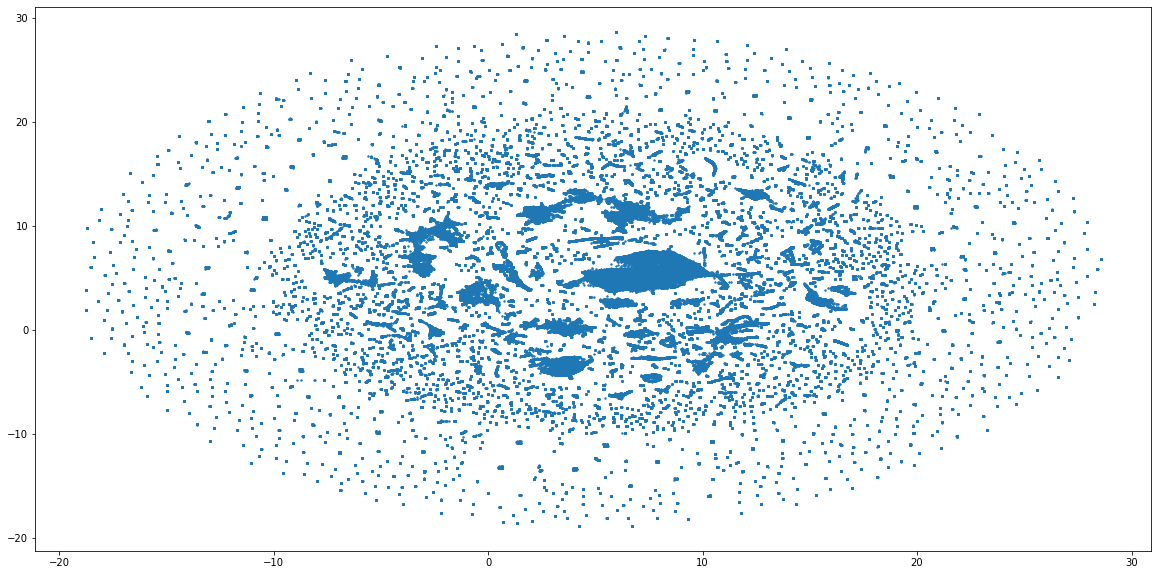

In [12]:
plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

## K-Prototypes

In [20]:
# full_data=df.copy(deep=True)
# import kmodes
# from kmodes.kprototypes import KPrototypes

In [21]:
# kprot_data = full_data.copy()
# #Pre-processing
# for c in full_data.select_dtypes(exclude='object').columns:
#     pt = PowerTransformer()
#     kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

# categorical_columns = [1,2,3] #make sure to specify correct indices

# #Actual clustering
# kproto = KPrototypes(n_clusters= 15, init='Cao', n_jobs = 4)
# clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

# #long à tourner : environ 8 min

In [22]:
# #Prints the count of each cluster group
# pd.Series(clusters).value_counts()

13    2984
2     2804
4     1988
11    1925
12    1757
3     1675
8     1526
14    1026
5      975
1      966
7      341
10     268
9      235
6      166
0       99
dtype: int64

In [23]:
# #OPTIONAL: Elbow plot with cost (will take a LONG time)
# costs = []
# n_clusters = []
# clusters_assigned = []

# for i in tqdm(range(2, 25)):
#     try:
#         kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
#         clusters = kproto.fit_predict(kprot_data, categorical=[0, 6, 7, 9, 13])
#         costs.append(kproto.cost_)
#         n_clusters.append(i)
#         clusters_assigned.append(clusters)
#     except:
#         print(f"Can't cluster with {i} clusters")
        
# fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
# fig.show()

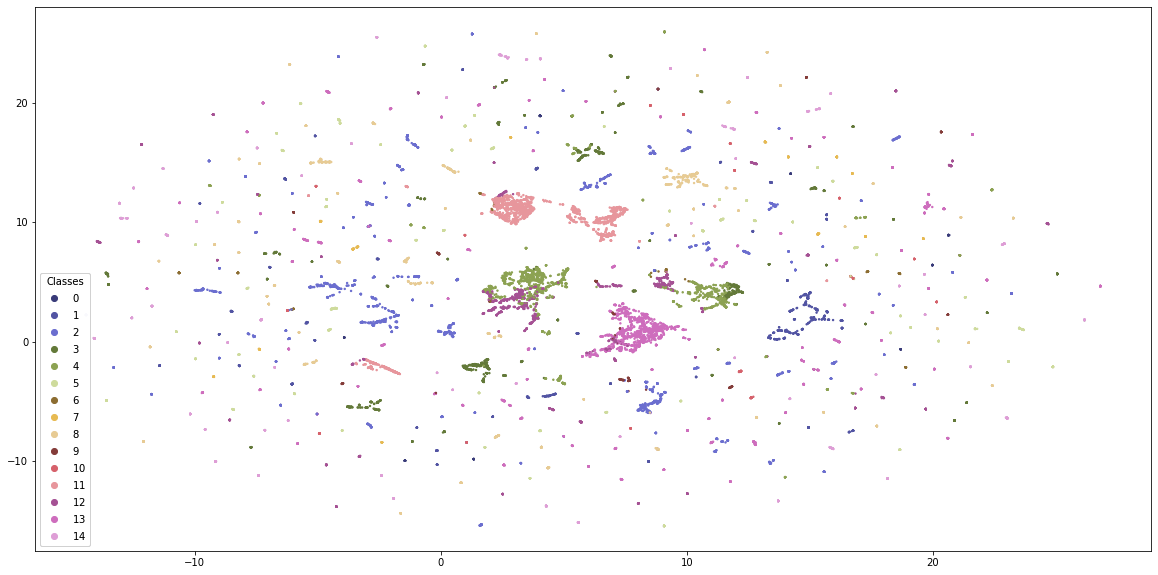

In [24]:
# fig, ax = plt.subplots()
# fig.set_size_inches((20, 10))
# embedding=embedding[0]
# scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# # produce a legend with the unique colors from the scatter
# legend1 = ax.legend(*scatter.legend_elements(num=15),
#                     loc="lower left", title="Classes")
# ax.add_artist(legend1)

## K-means (for mixed data)

In [4]:
full_data_R=df_R.copy(deep=True)
full_data_K=df_K.copy(deep=True)

In [5]:
#One-Hot-Encoding
data_R = pd.get_dummies(full_data_R)
data_K = pd.get_dummies(full_data_K)

#Pre-processing
for c in tqdm(data_R.columns):
    pt = PowerTransformer()
    data_R.loc[:, c] = pt.fit_transform(np.array(data_R[c]).reshape(-1, 1))
data_R.to_csv("Outputs/data_preprocessedKmeans_Rabi")

for c in tqdm(data_K.columns):
    pt = PowerTransformer()
    data_K.loc[:, c] = pt.fit_transform(np.array(data_K[c]).reshape(-1, 1))
data_R.to_csv("Outputs/data_preprocessedKmeans_Kharif")

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

In [6]:
#Actual Clustering

nb_clusters_R = 8
kmeans_R = KMeans(init="k-means++", n_clusters=nb_clusters_R, max_iter=500, n_init=6, random_state=0).fit(data_R)
kmeans_labels_R = kmeans_R.labels_
db_index = davies_bouldin_score(data_R, kmeans_labels_R)
print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

nb_clusters_K = 12
kmeans_K = KMeans(init="k-means++", n_clusters=nb_clusters_K, max_iter=500, n_init=6, random_state=0).fit(data_K)
kmeans_labels_K = kmeans_K.labels_
db_index = davies_bouldin_score(data_K, kmeans_labels_K)
print(f"db index for Rabi with k = {nb_clusters_K} : ", db_index)

db index for Rabi with k = 8 :  1.8403710218055318
db index for Rabi with k = 12 :  1.9135267483144232


In [1]:
#OPTIONAL: Elbow plot with inertia
#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 20)):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=4, max_iter=1000, random_state=0).fit(data_R)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.update_layout(title="Elbow plot for Rabi")

sse = {}
for k in tqdm(range(2, 20)):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=4, max_iter=1000, random_state=0).fit(data_K)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.update_layout(title="Elbow plot for Kharif")
fig.show()

NameError: name 'tqdm' is not defined

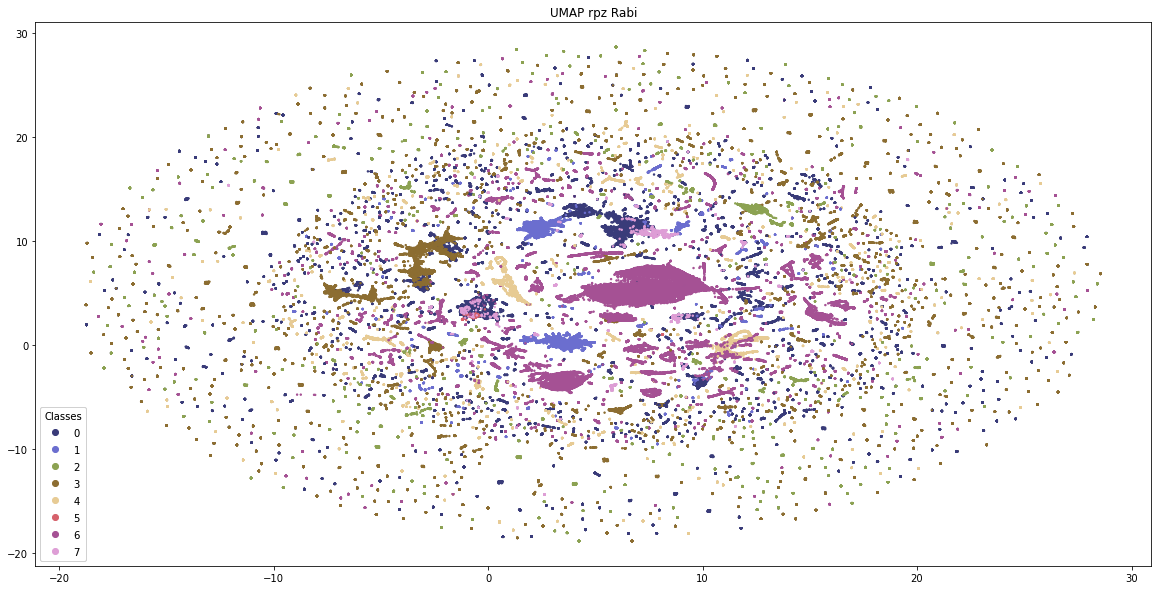

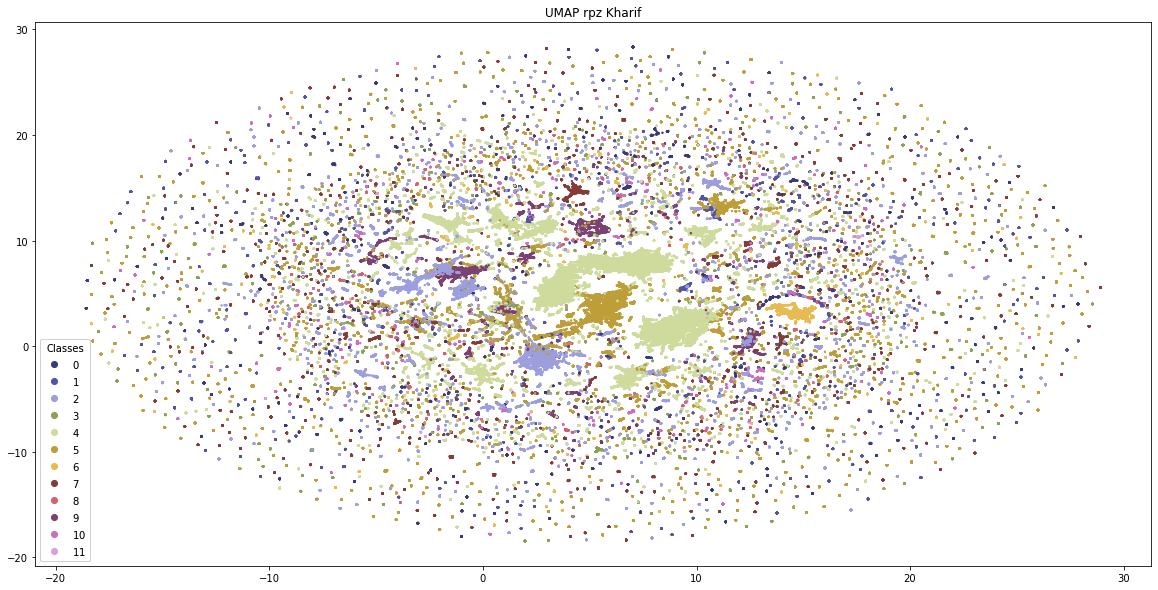

In [ ]:
embedding_R = np.load(f"Outputs/embedding_Rabi.npy")
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding_R[:, 0], embedding_R[:, 1], s=2, c=kmeans_labels_R, cmap='tab20b', alpha=1.0)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=nb_clusters_R),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.title("UMAP rpz Rabi")
plt.show()

embedding_K = np.load(f"Outputs/embedding_Kharif.npy")
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding_K[:, 0], embedding_K[:, 1], s=2, c=kmeans_labels_K, cmap='tab20b', alpha=1.0)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=nb_clusters_K),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.title("UMAP rpz Kharif")
plt.show()

In [ ]:
labels_R = pd.DataFrame(kmeans_labels_R)
databis_R=full_data_R.reset_index()
labeledData_R = pd.concat((databis_R,labels_R),axis=1)
labeledData_R = labeledData_R.rename({0:'labels'},axis=1)
labeledData_R=labeledData_R.set_index(labeledData_R['key']).drop(columns = ['key'])

labels_K = pd.DataFrame(kmeans_labels_K)
databis_K=full_data_K.reset_index()
labeledData_K = pd.concat((databis_K,labels_K),axis=1)
labeledData_K = labeledData_K.rename({0:'labels'},axis=1)
labeledData_K=labeledData_K.set_index(labeledData_K['key']).drop(columns = ['key'])
labeledData_K.head()

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Sum Insured (Inr),Indemnity Level,2002 Yield,2003 Yield,2004 Yield,2005 Yield,...,2010 Yield,2011 Yield,2012 Yield,2013 Yield,2014 Yield,2015 Yield,2016 Yield,2017 Yield,Loss,labels
key,,,,,,,,,,,,,,,,,,,,,
andhra pradesh_anantapur_agali__agali,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,150.820333,87.096222,108.775,70.0,295.0,89.0,99.0,2888.776861,14230.814316,7
andhra pradesh_anantapur_agali__akkagaladevarahalli,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,150.820333,87.096222,108.775,58.0,232.0,120.0,99.0,2888.776861,14464.016467,7
andhra pradesh_anantapur_agali__hulikeradevarahalli,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,150.820333,87.096222,108.775,67.0,295.0,89.0,99.0,2888.776861,14230.814316,7
andhra pradesh_anantapur_agali__inagalore,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,150.820333,87.096222,108.775,62.0,232.0,120.0,99.0,2888.776861,14464.016467,7
andhra pradesh_anantapur_agali__kodihalli,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,...,150.820333,87.096222,108.775,70.0,295.0,89.0,99.0,2888.776861,14230.814316,7


RABI


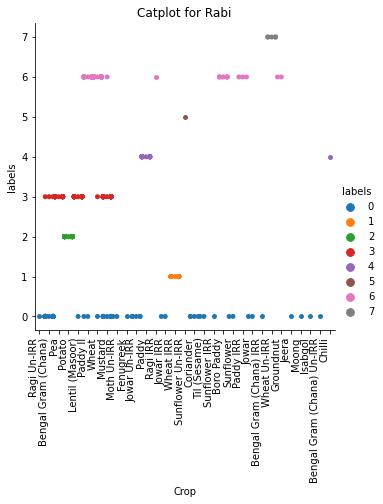

  0%|          | 0/4 [00:00<?, ?it/s]

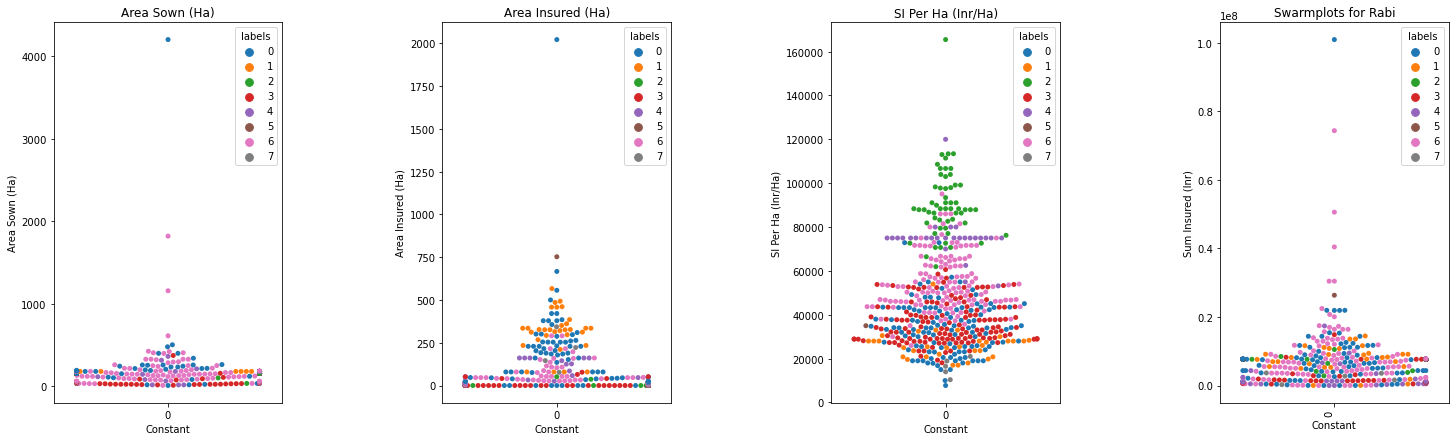

KHARIF


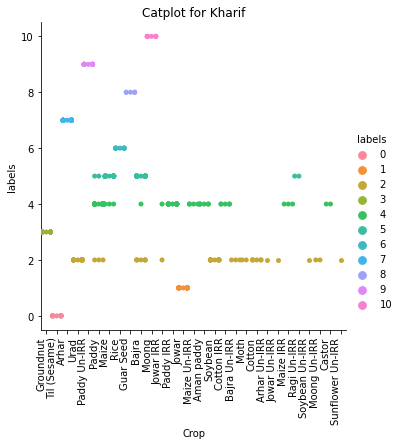

  0%|          | 0/4 [00:00<?, ?it/s]

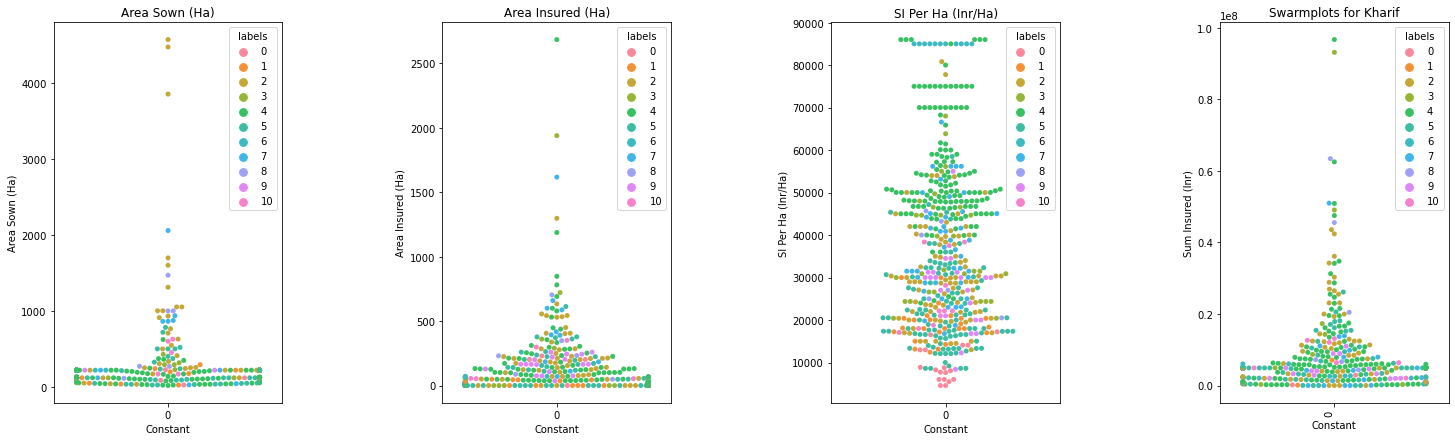

In [ ]:
#RABI
print("RABI")
labeledData_R.columns
sns.catplot(x='Crop', y='labels', kind="swarm", hue='labels', data=labeledData_R.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot for Rabi')
plt.show()
labeledData_R['Constant'] = 0 #dummy feature for plotting
f, axes = plt.subplots(1, 4, figsize=(25, 7), sharex=False)
f.subplots_adjust(hspace=0.2, wspace=0.7)
for i in trange(1,5):
    col = labeledData_R.columns[i]
    ax = sns.swarmplot(x='Constant',y=col,hue='labels',data=labeledData_R.sample(frac=1, random_state=0)[:500],ax=axes[i-1])
    plt.xticks(rotation=90, ha='right')
    ax.set_title(col)
plt.title('Swarmplots for Rabi')
plt.show()

#KHARIF
print("KHARIF")
labeledData_K.columns
sns.catplot(x='Crop', y='labels', kind="swarm", hue='labels', data=labeledData_K.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.title('Catplot for Kharif')
plt.show()
labeledData_K['Constant'] = 0 #dummy feature for plotting
f, axes = plt.subplots(1, 4, figsize=(25, 7), sharex=False)
f.subplots_adjust(hspace=0.2, wspace=0.7)
for i in trange(1,5):
    col = labeledData_K.columns[i]
    ax = sns.swarmplot(x='Constant',y=col,hue='labels',data=labeledData_K.sample(frac=1, random_state=0)[:500],ax=axes[i-1])
    plt.xticks(rotation=90, ha='right')
    ax.set_title(col)
plt.title('Swarmplots for Kharif')
plt.show()

## Implémentation critère cluster

db_index=  2.558336601485453 ,  k = 5
db_index=  2.38678237039245 ,  k = 6
db_index=  2.3124533911715415 ,  k = 7
db_index=  1.8403710218055318 ,  k = 8
db_index=  1.8811797911744574 ,  k = 9
db_index=  2.210266985859537 ,  k = 10
db_index=  2.494040984552678 ,  k = 11
db_index=  2.0296154916770424 ,  k = 12
db_index=  2.55132218146211 ,  k = 13
db_index=  1.3381109405690128 ,  k = 14
db_index=  2.2208430532031525 ,  k = 15
db_index=  2.3504388451645664 ,  k = 16


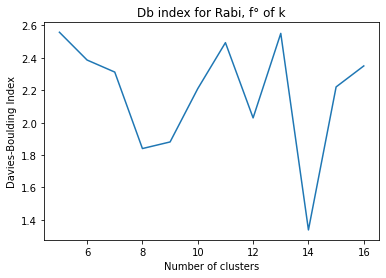

db_index=  2.869801364054703 ,  k = 5
db_index=  2.322566137094326 ,  k = 6
db_index=  2.4188025442984333 ,  k = 7
db_index=  2.316658657305544 ,  k = 8
db_index=  2.196131769639379 ,  k = 9
db_index=  2.0775037965869214 ,  k = 10
db_index=  1.9861431413184887 ,  k = 11
db_index=  1.9135267483144232 ,  k = 12
db_index=  1.7909155204223532 ,  k = 13
db_index=  1.8326836963511308 ,  k = 14
db_index=  1.7179073574484665 ,  k = 15
db_index=  1.46859874938922 ,  k = 16


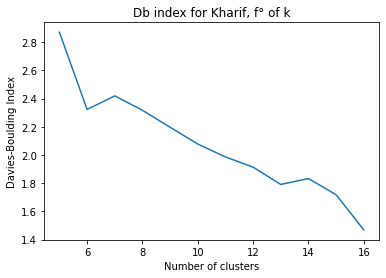

In [ ]:
#RABI
results = {}
for i in range(5,17):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=500, n_init=6, random_state=0).fit(data_R)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(data_R, labels)
    print("db_index= ", db_index, ",  k =", i)
    results.update({i: db_index})
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Boulding Index")
plt.title("Db index for Rabi, f° of k")
plt.show()

#KHARIF
results = {}
for i in range(5,17):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=500, n_init=6, random_state=0).fit(data_K)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(data_K, labels)
    print("db_index= ", db_index, ",  k =", i)
    results.update({i: db_index})
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Boulding Index")
plt.title("Db index for Kharif, f° of k")
plt.show()

#### Otptimal k :

for Rabi : 8 ou 14
for Kharif : décroissant

à retester